# Example: How to use me-types-mapper

In [1]:
import numpy as np
import pandas as pd

# Create toy datasets

In [2]:
from sklearn.datasets import make_blobs

N_samples_1, N_types_1 = 100, 6
N_samples_2, N_types_2 = 700, 14
N_features = 200
N_efeatures = 70

# Create datasets using make_blobs from sklearn
dataset_1, labels_1 = make_blobs(n_samples=N_samples_1, centers=N_types_1, n_features=N_features,
                                 cluster_std=3.0, center_box=(- 15.0, 15.0), )
dataset_2, labels_2 = make_blobs(n_samples=N_samples_2, centers=N_types_2, n_features=N_features,
                                 cluster_std=10.0, center_box=(- 10.0, 10.0), )

# Convert into panda DataFrame (needed to use me-types-mapper)
dataset_1 = pd.DataFrame(dataset_1, index = [np.float("100" + str(i)) for i in range(len(labels_1))])
dataset_2 = pd.DataFrame(dataset_2, index = ["dsetB_sample" + str(i) for i in range(len(labels_2))])

# Give cluster labels more explicit names
labels_1 = pd.DataFrame(["dsetA_clstr" + str(x) for x in labels_1], 
                        index = dataset_1.index)
labels_2 = pd.DataFrame(["dsetB_clstr" + str(x) for x in labels_2],
                        index = dataset_2.index)

labels = pd.concat([labels_1, labels_2], axis=0)[0]

# Create a mask to separate features into two subtypes (e.g. electorphysiological and morphological)
msk_efeat = np.asarray([True] * N_efeatures + [False] * (N_features - N_efeatures))


/Users/yroussel/Desktop/mapper_example/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


# Visualize dataset using PCA

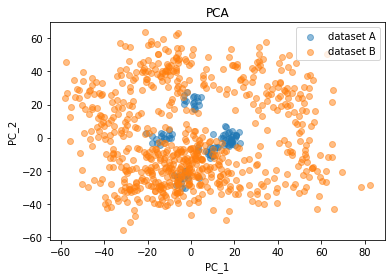

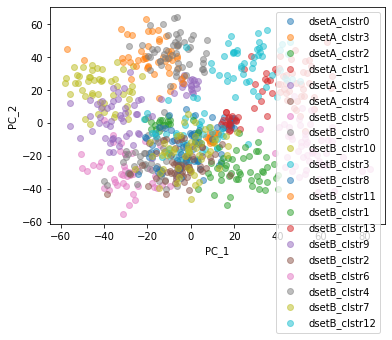

In [3]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

def plot_pca(X, labels, title):

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X)

    for lbl in labels.unique():
        msk = labels == lbl
        plt.scatter(embedding[:,0][msk], embedding[:,1][msk], alpha=0.5)
    plt.legend(labels.unique())
    plt.xlabel("PC_1")
    plt.ylabel("PC_2")
    plt.title(title)
    plt.show()
    return

data = pd.concat([dataset_1, dataset_2], axis=0)
lbls_dset = pd.DataFrame(["dataset A"] * len(labels_1) + ["dataset B"] * len(labels_2))[0]

plot_pca(data, lbls_dset, "PCA")
plot_pca(data, labels, "")


# Define common clusters using me-types-mapper

alpha = 0.5
d_opt =  89


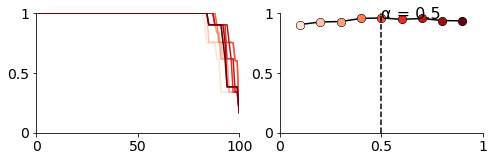

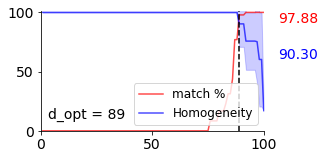

In [4]:
from me_types_mapper.mapper.coclustering_functions import cross_predictions_v2

(alpha_opt, map_, c1, c2, 
 dict_cluster_label, cluster_ref, fig_alpha, fig_d_opt) = cross_predictions_v2(dataset_1, dataset_2, 
                                                                               msk_efeat, ~msk_efeat, labels,
                                                                               alpha_list_ = np.arange(.1,1.,.1))


# Probabilistic mapping

In [5]:
# Prepare a dictionnary with sample index from both dataset as keys 
# and their attached common cluster (defined above) as values.
cell_id_list = dataset_1.index.tolist() + dataset_2.index.tolist()
cluster_ref_dict = {}
for cell_idx, cell_id in enumerate(cell_id_list):
    cluster_ref_dict[cell_id] = cluster_ref[cell_idx]

# Masks to split data from both datasets.
mask_tmp_1 = np.asarray([True] * len(labels_1) + [False] * len(labels_2))
mask_tmp_2 = ~mask_tmp_1

# probabilistic mapping
from me_types_mapper.mapper.coclustering_functions import compute_probabilistic_maps

p_maps = compute_probabilistic_maps(labels_2, 0, mask_tmp_2,
                                     labels_1, 0, mask_tmp_1,
                                     cluster_ref_dict)

# Plot the probabilistic map

Text(0.5, 1.0, 'P(cluster_datasetB|cluster_datasetA)')

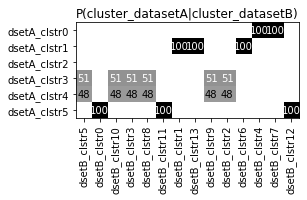

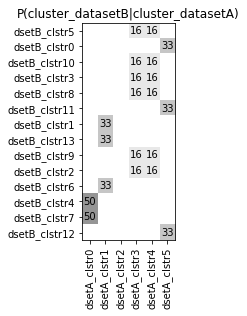

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_matrix(ax, X , axis_labels=True):
    X = X.div(np.sum(X, axis=0), axis=1).fillna(0)

    ax.imshow(X, vmin=0., vmax=1., cmap='Greys')
    if axis_labels:
        ax.set_xticks(np.arange(len(X.columns)))
        ax.set_xticklabels(X.columns, rotation=90)
        ax.set_yticks(np.arange(len(X.index)))
        ax.set_yticklabels(X.index)
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    # Loop over data dimensions and create text annotations.
    for i in range(len(X.index)):
        for j in range(len(X.columns)):
            if (X.values[i, j] > 0.5):
                text = ax.text(j, i, int(X.values[i, j] * 100),
                               ha="center", va="center", color="w")
            elif (0.1 < X.values[i, j] <= 0.5):
                text = ax.text(j, i, int(X.values[i, j] * 100),
                               ha="center", va="center", color="k")

    return

fig, ax = plt.subplots(1, figsize=(4,4))
plot_matrix(ax, p_maps[-1], axis_labels=True)
ax.set_title("P(cluster_datasetA|cluster_datasetB)")

fig2, ax2 = plt.subplots(1, figsize=(4,4))
plot_matrix(ax2, p_maps[-2], axis_labels=True)
ax2.set_title("P(cluster_datasetB|cluster_datasetA)")